In [1]:
# import libraries
import gym
import numpy as np
from gym import wrappers
import matplotlib.pyplot as plt
from itertools import count
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
import random
import math
from ReplayMemory import ReplayMemory
from DQN import DQN
from utilities import utilities as utl
from collections import namedtuple

/Users/chikaze/.conda/envs/pythonProject/lib/python3.8/site-packages/torchvision/transforms/transforms.py:257: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


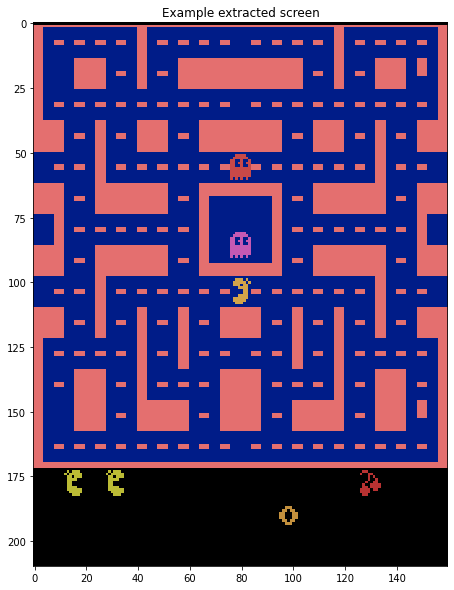

In [2]:
# create an environment
env = gym.make('MsPacman-v0')
env.reset()

# record video of the agent playing the game
env = wrappers.Monitor(env, 'tmp', video_callable=lambda episode_id: True, force=True)

plt.figure(figsize=(10,10))
plt.imshow(utl.get_screen(env).cpu().squeeze(0).permute(1, 2, 0).numpy(),
           interpolation='none')
plt.title('Example extracted screen')
plt.show()

In [3]:
def optimize_model(memory,policy_net,target_net):
    BATCH_SIZE = 128
    GAMMA = 0.999    
    Transition = namedtuple('Transition',
            ('state', 'action', 'next_state', 'reward'))
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q value
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V
    next_state_values = torch.zeros(BATCH_SIZE)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()

    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

In [4]:
# run it for 10 episodes
policy_net = DQN(210, 160, 9)
target_net = DQN(210, 160, 9)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

TARGET_UPDATE = 10

optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(1000)

steps_done = 0
episode_durations = []
num_episodes = 10
results = []

for i_episode in range(num_episodes):
    # Initialize the environment and state
    env.reset()
    last_screen = utl.get_screen(env)
    current_screen = utl.get_screen(env)
    state = current_screen - last_screen
    total_rewards = 0
    for t in count():
        # Select and perform an action
        action = utl.select_action(state,steps_done,policy_net)
        _, reward, done, _ = env.step(action.item())
        reward = torch.tensor([reward])

        # Observe new state
        last_screen = current_screen
        current_screen = utl.get_screen(env)
        if not done:
            next_state = current_screen - last_screen
        else:
            next_state = None

        # Store the transition in memory
        memory.push(state, action, next_state, reward)
        total_rewards += float(reward)
        steps_done += 1

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model(memory,policy_net,target_net)
        
        if done:
            episode_durations.append(t + 1)
            #plot_durations()
            break
    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())
    
    results.append(float(total_rewards))
    print('episode',i_episode,'done', total_rewards)

print('Complete')

/Users/chikaze/.conda/envs/pythonProject/lib/python3.8/site-packages/torchvision/transforms/transforms.py:257: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


episode 0 done 350.0


/Users/chikaze/.conda/envs/pythonProject/lib/python3.8/site-packages/torchvision/transforms/transforms.py:257: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


episode 1 done 180.0


/Users/chikaze/.conda/envs/pythonProject/lib/python3.8/site-packages/torchvision/transforms/transforms.py:257: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


episode 2 done 200.0


/Users/chikaze/.conda/envs/pythonProject/lib/python3.8/site-packages/torchvision/transforms/transforms.py:257: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


episode 3 done 230.0


/Users/chikaze/.conda/envs/pythonProject/lib/python3.8/site-packages/torchvision/transforms/transforms.py:257: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


episode 4 done 590.0


/Users/chikaze/.conda/envs/pythonProject/lib/python3.8/site-packages/torchvision/transforms/transforms.py:257: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


episode 5 done 330.0


/Users/chikaze/.conda/envs/pythonProject/lib/python3.8/site-packages/torchvision/transforms/transforms.py:257: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


episode 6 done 220.0


/Users/chikaze/.conda/envs/pythonProject/lib/python3.8/site-packages/torchvision/transforms/transforms.py:257: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


episode 7 done 210.0


/Users/chikaze/.conda/envs/pythonProject/lib/python3.8/site-packages/torchvision/transforms/transforms.py:257: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


episode 8 done 90.0


/Users/chikaze/.conda/envs/pythonProject/lib/python3.8/site-packages/torchvision/transforms/transforms.py:257: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


episode 9 done 280.0
Complete


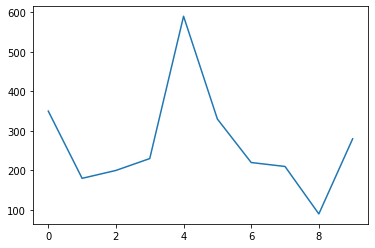

In [5]:
plt.plot(results)

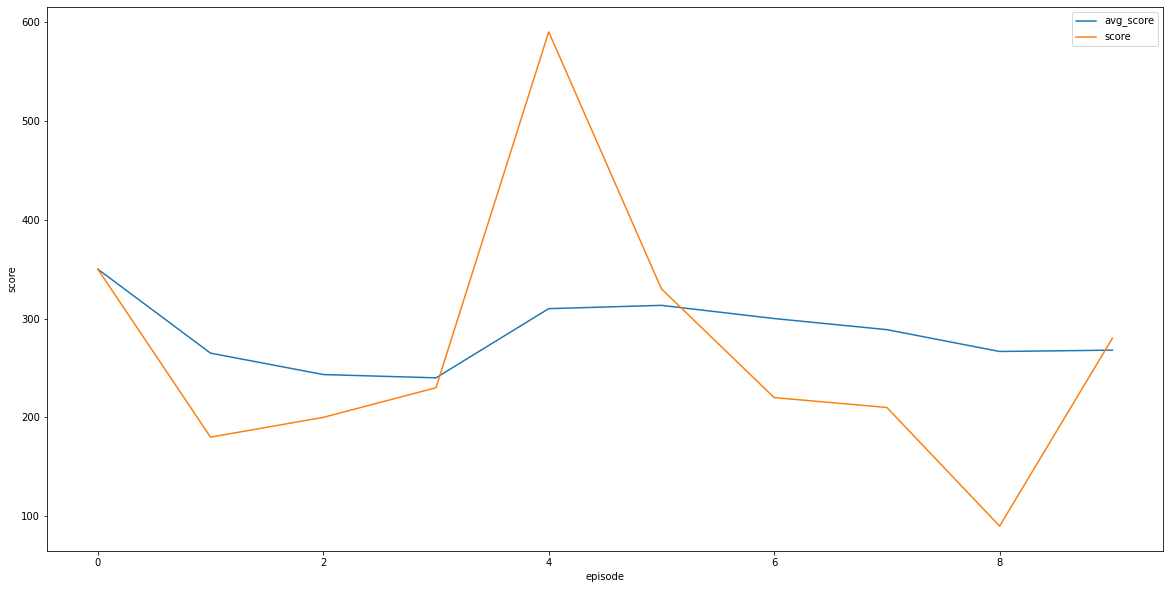

In [13]:
# visualise the result with the average scores
import pandas as pd
avg_scores = []
total = 0
count = 1
episodes = []
for score in results:
    total += score
    avg_scores.append(total/count)
    episodes.append(count-1)
    count += 1
df = pd.DataFrame({'episode':episodes,'score':results,'avg_score':avg_scores})
plt.figure(figsize=(20,10))
plt.plot(df['episode'],df['avg_score'], label='avg_score')
plt.plot(df['episode'],df['score'], label='score')
plt.xlabel('episode')
plt.ylabel('score')
plt.legend()
plt.show()